In this notebook, we apply pyMAISE to a 2D rod ejection data set. Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. Refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/benchmarks/mit_reactor.html) notebook for an in-depth tutorial. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# NEACRP C1 Rod Ejection Accident

**Inputs**

- `rod_worth`: Reactivity worth of the ejected rod
- `beta`: Delayed neutron fraction 
- `h_gap`: Gap conductance ($\frac{W}{m^2 \cdot K}$)
- `gamma_frac`: Direct heating fraction

**Outputs**

- `max_power`: peak power ($\% FP$)
- `burst_width`: Width of power burst ($s$)
- `max_TF`: Max fuel centerline temperature ($K$)
- `avg_Tcool`: Average coolant temperature at the outlet ($K$)

The NEACRP C1 rod ejection accident (REA) data represents one benchmark for reactor transient analysis. The data set is used to find the relationship between the REA/reactor parameters and the power/thermal behavior of the system during/after the event. Therefore, the data set is constructed by perturbing the inputs listed above—the corresponding output results in values of interest to the safety analysis of the transient. The data were generated using deterministic simulations by the PARCS code, where the data set size includes 2000 samples. The goal is to use pyMAISE to build, tune, and compare the performance of various ML models in predicting the transient outcomes based on the REA properties.

In [3]:
from pyMAISE.datasets import load_rea
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## Preprocessing

We define a pyMAISE regression problem and load the REA data.

In [4]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)
data, inputs, outputs = load_rea()

As stated the data set consists of 4 inputs:

In [5]:
inputs

<xarray.DataArray (index: 2000, variable: 4)>
array([[8.63781014e-03, 7.57558927e-03, 1.37279819e+04, 2.39566042e-02],
       [9.25495922e-03, 7.52915145e-03, 9.37021808e+03, 1.97072356e-02],
       [8.04631321e-03, 7.64737606e-03, 9.96254385e+03, 2.00446440e-02],
       ...,
       [8.72425595e-03, 7.47087165e-03, 1.10723962e+04, 1.53597012e-02],
       [9.11742702e-03, 7.49571772e-03, 1.08772638e+04, 1.73452589e-02],
       [8.35065112e-03, 7.63110349e-03, 1.34164011e+04, 1.71329041e-02]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'rod_worth' 'beta' 'h_gap' 'gamma_frac'

and 4 outputs with 2000 total data points:

In [6]:
outputs

<xarray.DataArray (index: 2000, variable: 4)>
array([[1.81210000e+02, 3.15000000e-01, 9.18300000e+02, 5.61119081e+02],
       [4.74590000e+02, 2.50000000e-01, 9.65200000e+02, 5.62030035e+02],
       [4.40830000e+01, 4.25000000e-01, 8.75700000e+02, 5.60194700e+02],
       ...,
       [2.55980000e+02, 2.90000000e-01, 9.36100000e+02, 5.61324028e+02],
       [4.27900000e+02, 2.55000000e-01, 9.57800000e+02, 5.61933922e+02],
       [9.69710000e+01, 3.80000000e-01, 8.98000000e+02, 5.60613781e+02]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'max_power' 'burst_width' 'max_Tf' 'avg_Tcool'

Prior to constructing any models we can get a surface understanding of the data set with a correlation matrix.

(<Figure size 800x800 with 2 Axes>, <Axes: >)

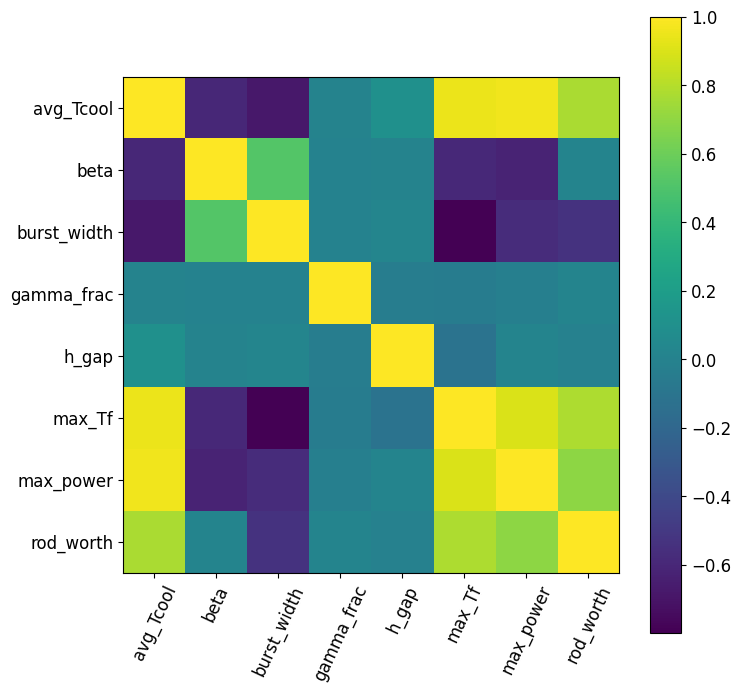

In [7]:
correlation_matrix(data)

A positive correlation exists between average coolant temperature and max fuel temperature, max power, and rod worth. The delayed neutron fraction and burst width negatively correlate with max fuel temperature, max power, and rod worth.

We train/test split into 70%/30% and scale inputs and outputs using min-max scaling to optimize model training.

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 6 regression models in this data set:

- linear: `Linear`,
- lasso: `Lasso`,
- decision tree: `DT`,
- random forest: `RF`,
- k-nearest neighbors regression: `KN`,
- dense feedforward neural network: `FNN`.

For hyperparameter tuning, we initialize all classical models as scikit-learn defaults. For the FNN, we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, the use of sublayers, and the dropout rate. The dense hidden layers include tuning of their depth.

In [9]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

We use a random search with 200 iterations and five cross-validation splits (1000 fits per model) for the classical models. The hyperparameter search space is defined for all but linear regression in which the default scikit-learn configuration will be tested. For the FNN, we use a Bayesian search with 50 iterations and five cross-validation splits (250 fits total). This offers possible convergence on an optimal configuration without taking excessive time. Classical models tend to be simpler than neural networks, so many random search iterations are possible.

In [10]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 17s]
r2_score: 0.9836683699270795

Best r2_score So Far: 0.9878710594597736
Total elapsed time: 00h 14m 55s
Hyperparameter tuning took 34.1222486615181 minutes to process.


Here is the convergence plot of the Bayesian search:

(0.0, 1.0)

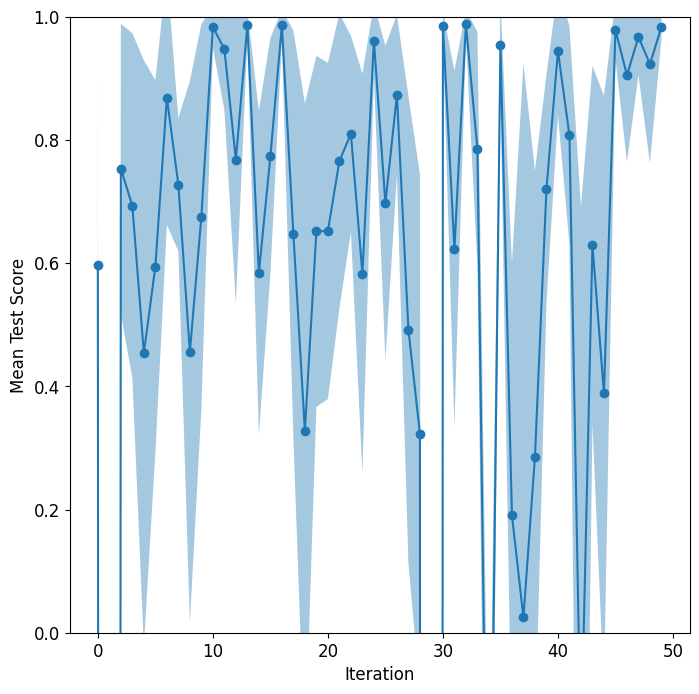

In [11]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])

## Post-processing

We can now pass these parameter configurations to the `pyMAISE.PostProcessor` for model evaluation. We increase the neural network epochs to 200 to improve their fit.

In [12]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

To compare the performance of these models, we compute four metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\hat{y}$ is the model predicted outcome, and $n$ is the number of observations. The averaged performance metrics are shown below.

In [13]:
postprocessor.metrics(y="max_power")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
21,FNN,"{'Dense_input_0_units': 142, 'Dense_input_0_su...",0.999861,1.701572,6.047820,2.459232,0.999679,1.711898,14.019047,3.744202
24,FNN,"{'Dense_input_0_units': 116, 'Dense_input_0_su...",0.999815,1.977899,8.029850,2.833699,0.999339,2.237440,28.852606,5.371462
25,FNN,"{'Dense_input_0_units': 297, 'Dense_input_0_su...",0.999211,4.285362,34.336528,5.859738,0.999181,4.364822,35.777393,5.981421
23,FNN,"{'Dense_input_0_units': 389, 'Dense_input_0_su...",0.999126,5.340259,38.031707,6.166985,0.998989,5.285953,44.136009,6.643494
22,FNN,"{'Dense_input_0_units': 195, 'Dense_input_0_su...",0.998845,5.526987,50.270627,7.090178,0.998722,5.574275,55.795904,7.469666
13,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.997148,5.858667,124.071636,11.138745,0.993912,9.419106,265.810697,16.303702
11,RF,"{'criterion': 'absolute_error', 'max_features'...",0.998310,4.919671,73.543027,8.575723,0.993805,9.415033,270.500781,16.446908
12,RF,"{'criterion': 'poisson', 'max_features': None,...",0.997027,5.949409,129.368407,11.374023,0.993729,9.506754,273.805354,16.547065
14,RF,"{'criterion': 'absolute_error', 'max_features'...",0.994933,7.599971,220.473464,14.848349,0.992181,10.744375,341.405218,18.477154
15,RF,"{'criterion': 'absolute_error', 'max_features'...",0.993780,8.293063,270.638911,16.451107,0.991476,11.076896,372.183956,19.292070


For max power, all but linear and lasso regression have tested $R^2$ greater than 0.95. The FNN and random forest models performed exceptionally with test $R^2$ greater than 0.99.

In [14]:
postprocessor.metrics(y="burst_width")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
25,FNN,"{'Dense_input_0_units': 297, 'Dense_input_0_su...",0.995148,0.003692,0.000075,0.008640,0.996239,0.004488,0.000069,0.008308
21,FNN,"{'Dense_input_0_units': 142, 'Dense_input_0_su...",0.993629,0.004069,0.000098,0.009900,0.993310,0.005079,0.000123,0.011079
24,FNN,"{'Dense_input_0_units': 116, 'Dense_input_0_su...",0.995174,0.003585,0.000074,0.008616,0.992479,0.004649,0.000138,0.011748
22,FNN,"{'Dense_input_0_units': 195, 'Dense_input_0_su...",0.992040,0.007887,0.000122,0.011065,0.991597,0.008793,0.000154,0.012418
23,FNN,"{'Dense_input_0_units': 389, 'Dense_input_0_su...",0.987996,0.007012,0.000185,0.013589,0.988338,0.007940,0.000214,0.014629
12,RF,"{'criterion': 'poisson', 'max_features': None,...",0.976434,0.005012,0.000363,0.019040,0.955039,0.009137,0.000825,0.028723
11,RF,"{'criterion': 'absolute_error', 'max_features'...",0.987942,0.003760,0.000185,0.013619,0.954303,0.008763,0.000839,0.028957
13,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.977931,0.005037,0.000339,0.018425,0.946676,0.009679,0.000978,0.031281
15,RF,"{'criterion': 'absolute_error', 'max_features'...",0.959372,0.006079,0.000625,0.025000,0.945736,0.009624,0.000996,0.031555
14,RF,"{'criterion': 'absolute_error', 'max_features'...",0.964293,0.005743,0.000549,0.023437,0.940835,0.009872,0.001086,0.032949


For burst width k-nearest neighbors, decision tree, lasso, and linear regression largely struggled. K-nearest neighbors are overfit. The top performers were the FNN and random forest models; however, the FNN was more consistent between training and testing.

In [15]:
postprocessor.metrics(y="max_Tf")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
21,FNN,"{'Dense_input_0_units': 142, 'Dense_input_0_su...",0.999653,0.436207,0.434606,0.659247,0.999477,0.491250,0.689558,0.830396
22,FNN,"{'Dense_input_0_units': 195, 'Dense_input_0_su...",0.999677,0.479604,0.404094,0.635684,0.999468,0.516444,0.701467,0.837536
25,FNN,"{'Dense_input_0_units': 297, 'Dense_input_0_su...",0.999541,0.598321,0.573899,0.757561,0.999304,0.633136,0.918486,0.958377
23,FNN,"{'Dense_input_0_units': 389, 'Dense_input_0_su...",0.999507,0.589491,0.617415,0.785758,0.999299,0.662084,0.924974,0.961756
24,FNN,"{'Dense_input_0_units': 116, 'Dense_input_0_su...",0.997719,1.513531,2.853706,1.689292,0.997493,1.555289,3.308143,1.818830
11,RF,"{'criterion': 'absolute_error', 'max_features'...",0.996664,1.410116,4.173507,2.042916,0.988848,2.629561,14.717958,3.836399
12,RF,"{'criterion': 'poisson', 'max_features': None,...",0.992346,2.186545,9.575859,3.094489,0.986403,3.012870,17.943818,4.236014
13,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.992365,2.186774,9.551940,3.090621,0.985841,3.042711,18.685498,4.322673
14,RF,"{'criterion': 'absolute_error', 'max_features'...",0.989563,2.475077,13.057545,3.613522,0.984309,3.198438,20.707569,4.550557
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.983840,2.715447,20.217685,4.496408,0.983938,2.915761,21.197299,4.604052


Max fuel temperature is a more linear label, with all models performing well with $R^2$ greater than 0.95. Once again, the FNN and random forest models were the top-performing models.

In [16]:
postprocessor.metrics(y="avg_Tcool")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
25,FNN,"{'Dense_input_0_units': 297, 'Dense_input_0_su...",0.999896,0.006207,0.000058,0.007620,0.999876,0.006692,0.000073,0.008565
22,FNN,"{'Dense_input_0_units': 195, 'Dense_input_0_su...",0.999888,0.006032,0.000062,0.007902,0.999856,0.007010,0.000086,0.009248
21,FNN,"{'Dense_input_0_units': 142, 'Dense_input_0_su...",0.999793,0.009157,0.000115,0.010725,0.999804,0.009080,0.000116,0.010785
24,FNN,"{'Dense_input_0_units': 116, 'Dense_input_0_su...",0.999668,0.011642,0.000185,0.013593,0.999617,0.012398,0.000228,0.015085
23,FNN,"{'Dense_input_0_units': 389, 'Dense_input_0_su...",0.999351,0.016766,0.000361,0.018999,0.999342,0.017183,0.000391,0.019765
11,RF,"{'criterion': 'absolute_error', 'max_features'...",0.997738,0.024164,0.001259,0.035477,0.993208,0.043819,0.004030,0.063482
13,RF,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.995018,0.035910,0.002772,0.052646,0.991341,0.050395,0.005138,0.071679
12,RF,"{'criterion': 'poisson', 'max_features': None,...",0.995058,0.035372,0.002749,0.052433,0.991247,0.050459,0.005194,0.072068
14,RF,"{'criterion': 'absolute_error', 'max_features'...",0.992714,0.043646,0.004054,0.063667,0.990189,0.054513,0.005822,0.076299
15,RF,"{'criterion': 'absolute_error', 'max_features'...",0.991341,0.047579,0.004817,0.069405,0.989707,0.055976,0.006108,0.078151


Average coolant temperature was also well predicted by all models.

In [17]:
postprocessor.metrics()[["Model Types", "Train R2", "Test R2"]]

,Model Types,Train R2,Test R2
25,FNN,0.998449,0.998650
21,FNN,0.998234,0.998068
22,FNN,0.997612,0.997411
24,FNN,0.998094,0.997232
23,FNN,0.996495,0.996492
11,RF,0.995163,0.982541
12,RF,0.990216,0.981604
13,RF,0.990616,0.979443
15,RF,0.983085,0.977660
14,RF,0.985376,0.976878


Overall, the top-performing models are the FNNs, some of which are above 0.99 $R^2$ for training and testing data sets. Linear and lasso regression were the worst-performing models.

Below are the hyperparameter configurations of each of the top-performing models.

In [18]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00016630201422155415

Model Types: DT
max_depth: 46
max_features: None
min_samples_leaf: 2
min_samples_split: 3

Model Types: RF
criterion: absolute_error
max_features: 6
min_samples_leaf: 1
min_samples_split: 4
n_estimators: 55

Model Types: KN
leaf_size: 28
n_neighbors: 4
p: 2
weights: distance

Model Types: FNN
Dense_input_0_units: 297
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.4
Dense_hidden_num_layers: 1
Adam_learning_rate: 0.00042464726248941616
Dense_hidden_0_units: 250
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.5438320008274821
batch_size: 16
Dense_hidden_1_units: 78
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.5294318804652345
Dense_hidden_2_units: 83
Dense_hidden_2_sublayer: None
Dense_hidden_2_sublayer_Dropout_hidden_0_rate: 0.5395583542346409



We can visualize the performance of each model with diagonal validation plots. These plots show the predicted output to the actual production. The performance of FNN is apparent with the spread close around $y= x$. Random forest, k-nearest neighbors, and decision tree performed relatively well on all outputs. Burst width is the most difficult to predict for all the models.

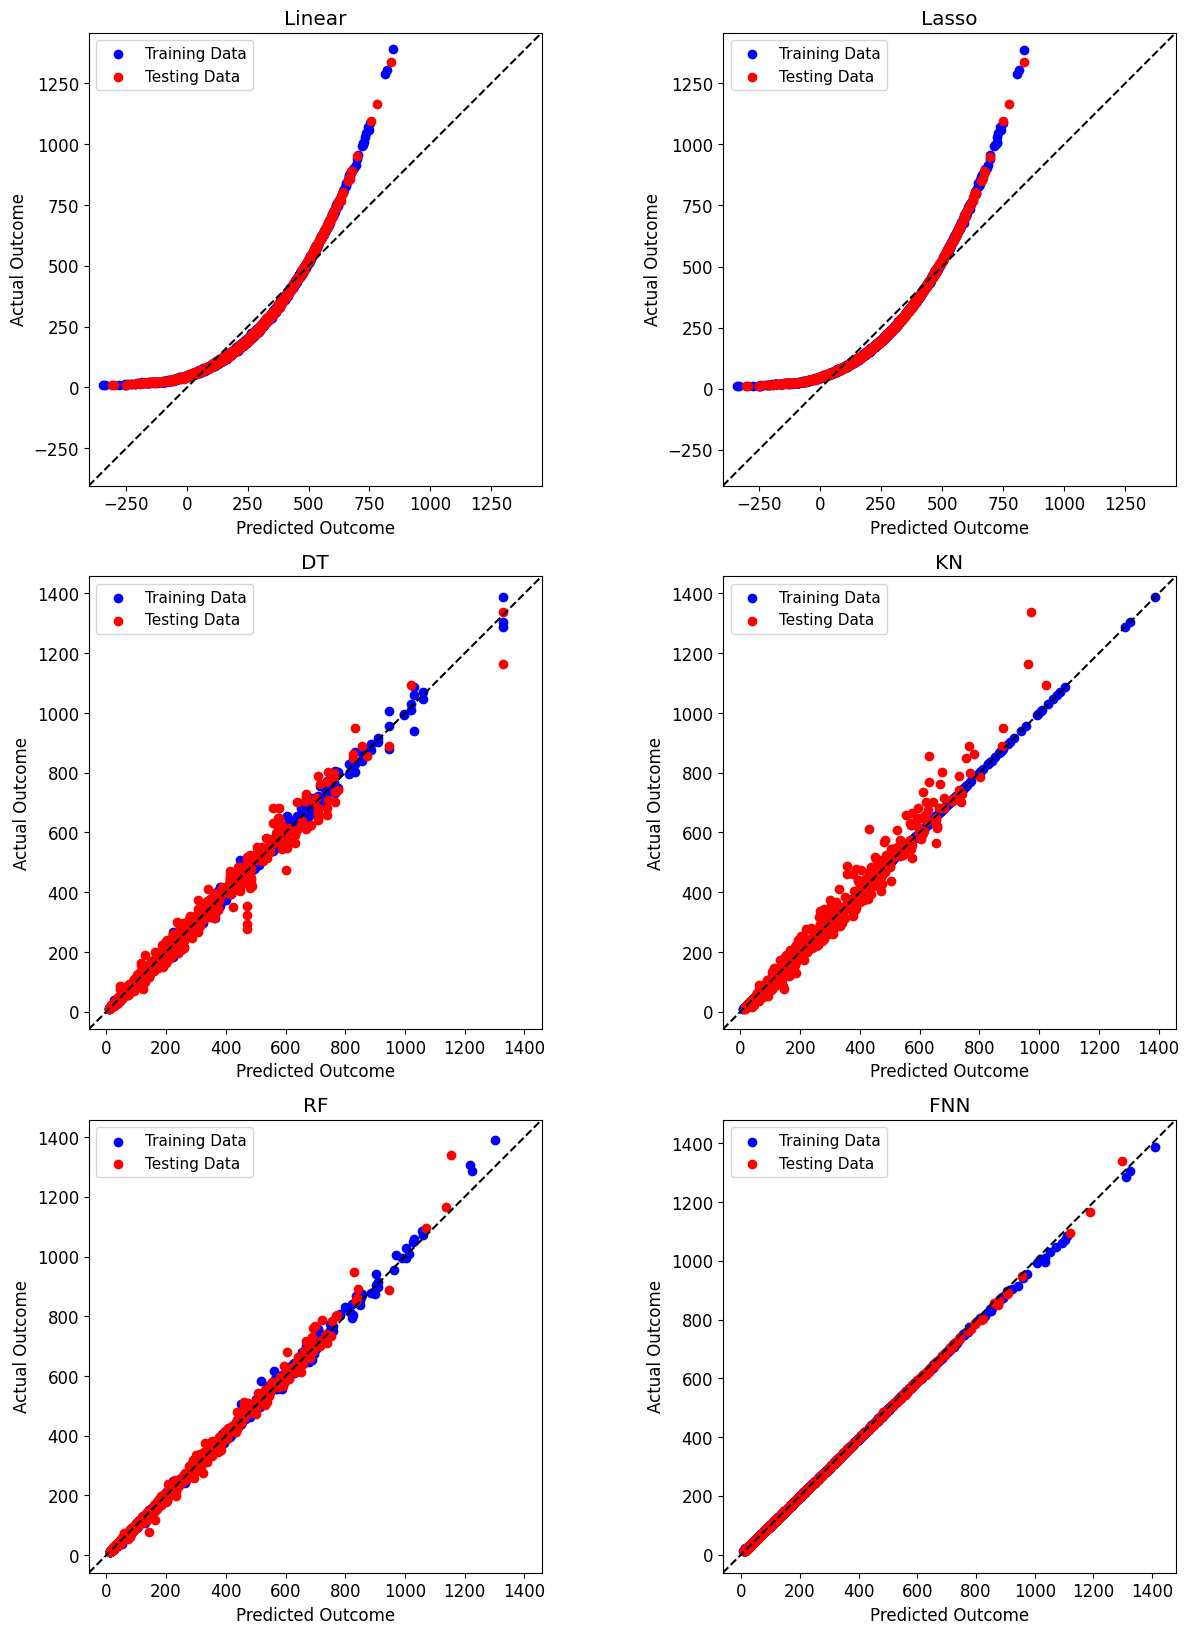

In [19]:
def performance_plot(meth, output):
    models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
    fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(15,20))
    for i in range(models.shape[0]):
        for j in range(models.shape[1]):
            plt.sca(axarr[i, j])
            axarr[i, j] = meth(model_type=models[i, j], y=[output])
            axarr[i, j].set_title(models[i, j])


performance_plot(postprocessor.diagonal_validation_plot, "max_power")

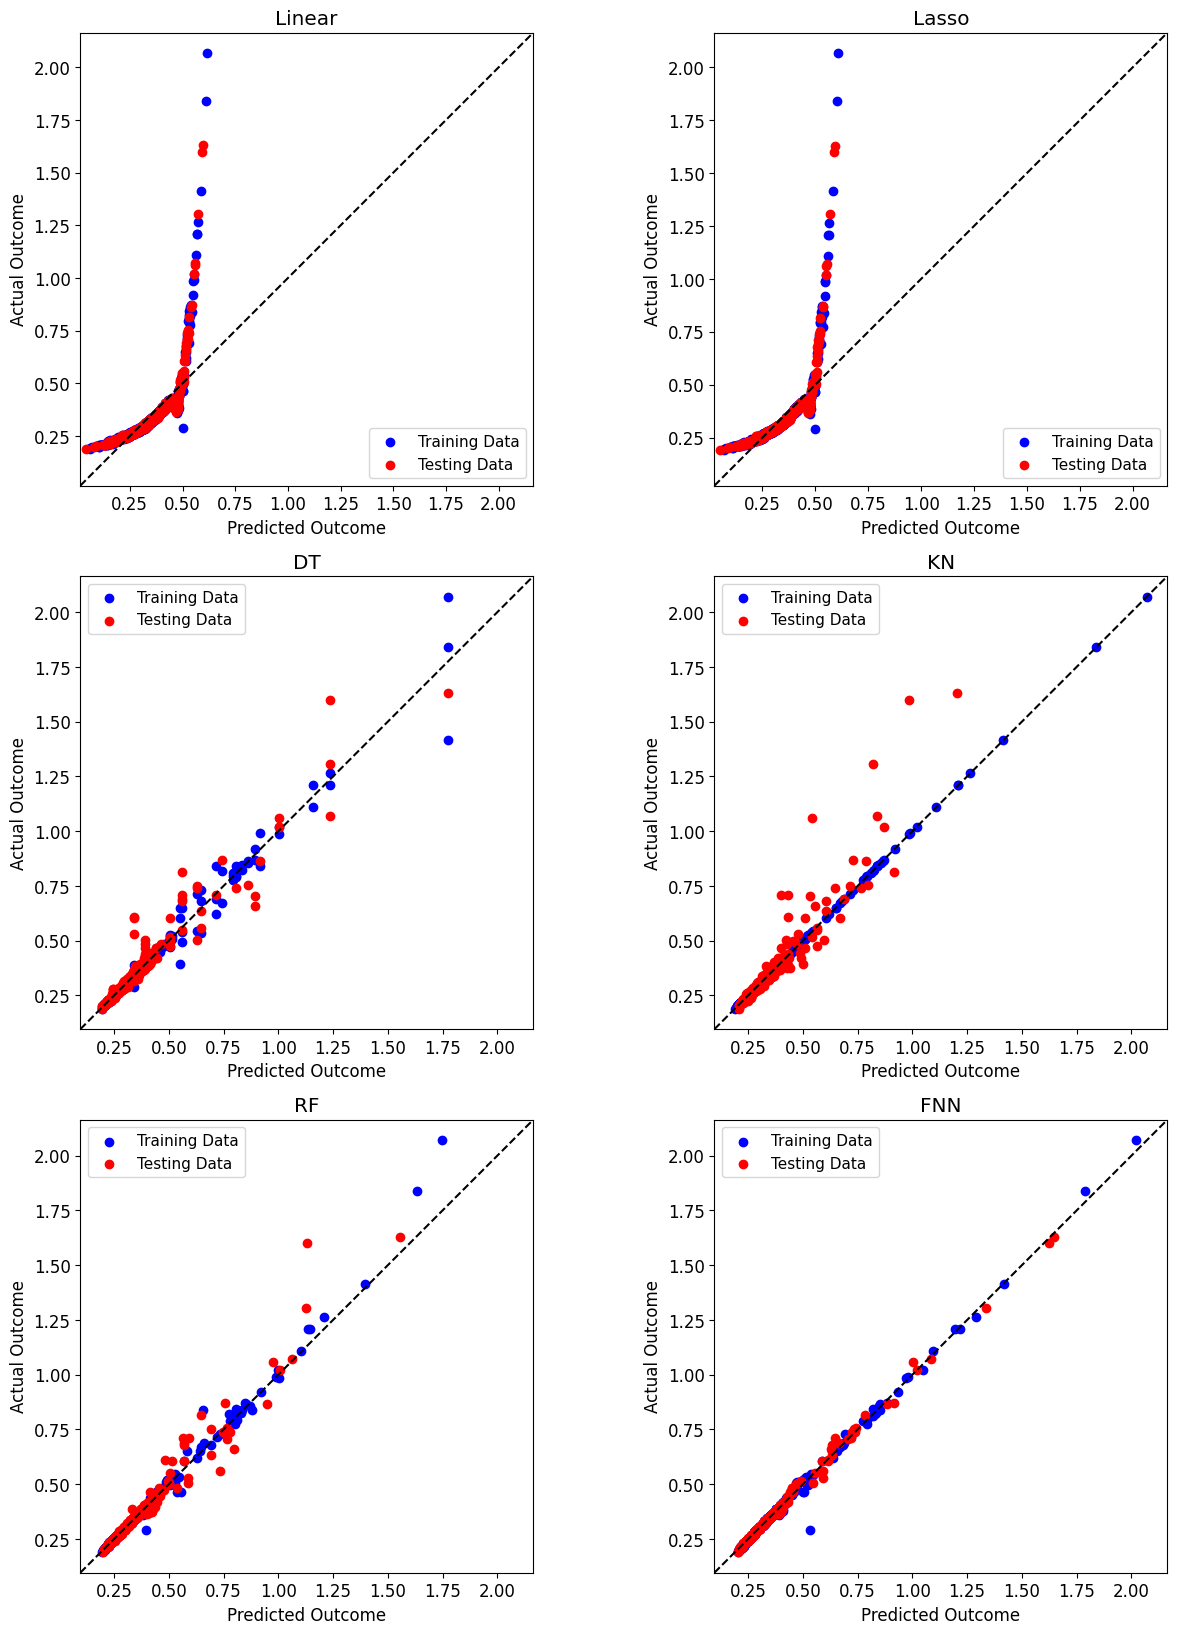

In [20]:
performance_plot(postprocessor.diagonal_validation_plot, "burst_width")

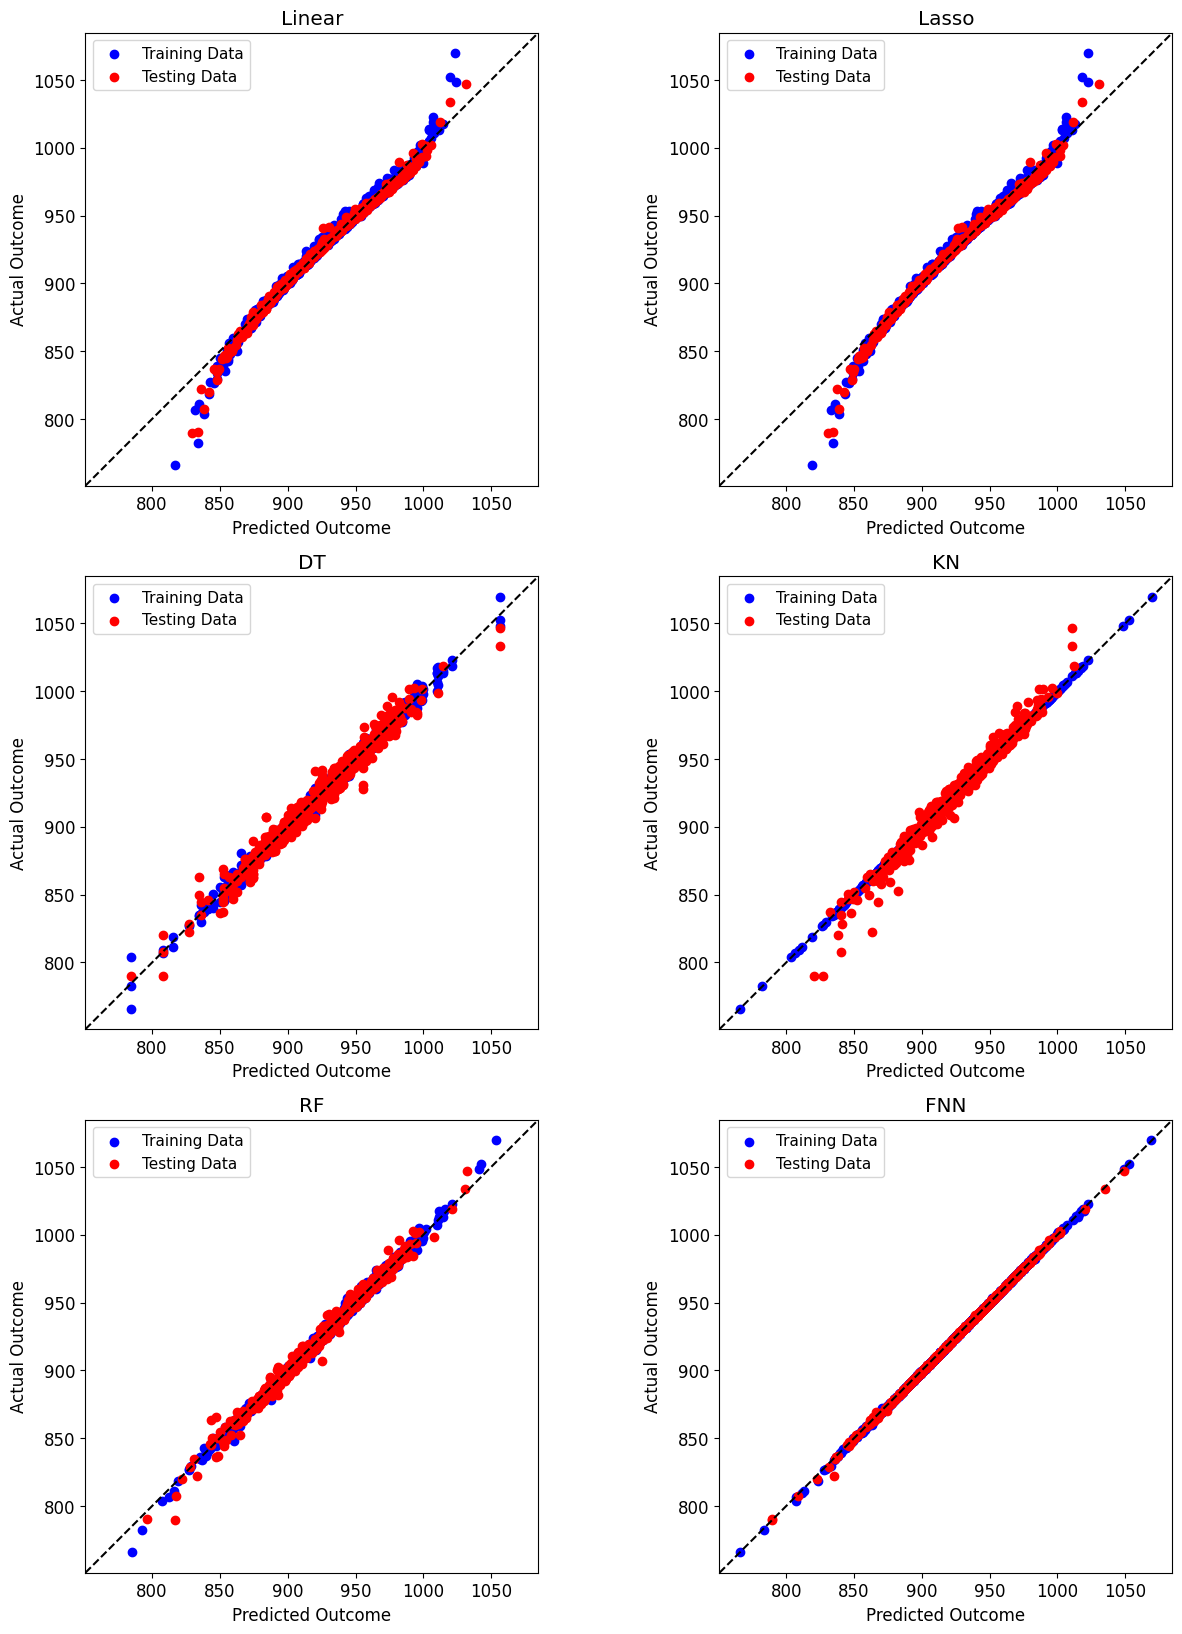

In [21]:
performance_plot(postprocessor.diagonal_validation_plot, "max_Tf")

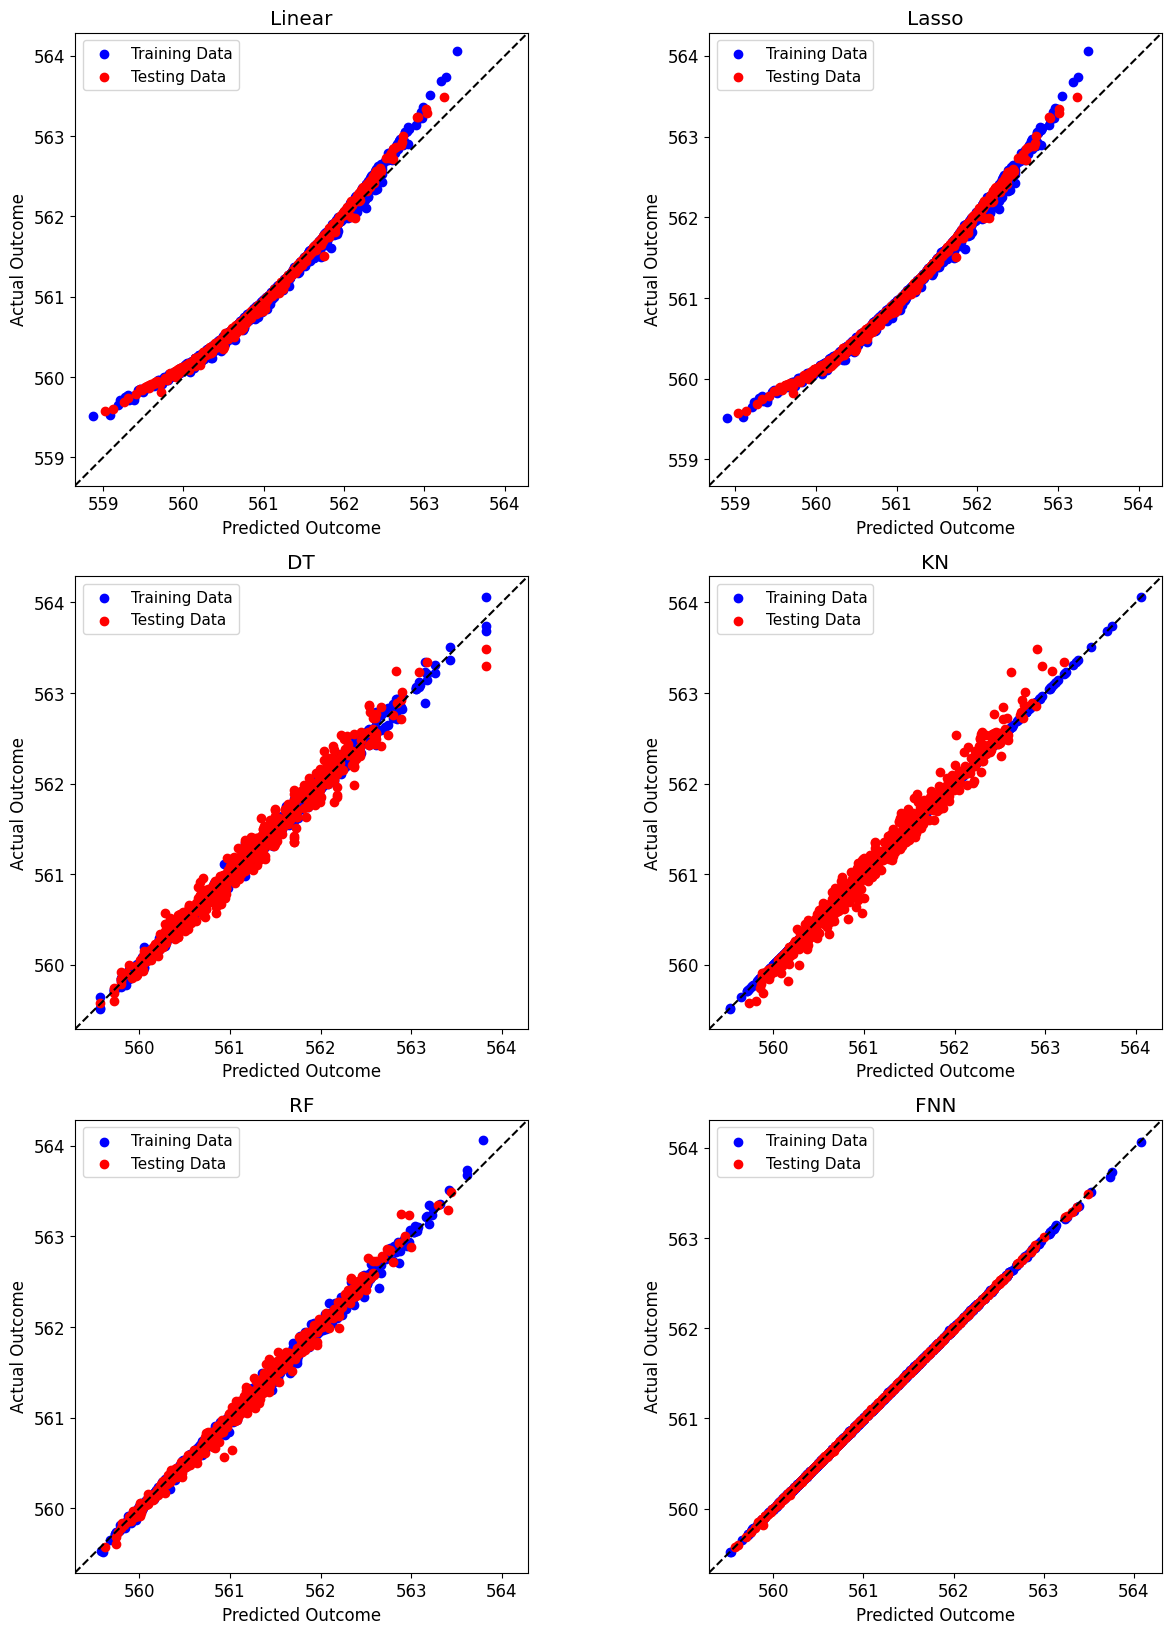

In [22]:
performance_plot(postprocessor.diagonal_validation_plot, "avg_Tcool")

The validation plots for all outputs are given below. Based on the scaling of the $y$-axis, we can see that the FNNs performed the best. Both the diagonal validation and validation plots agree with the performance metrics presented above.

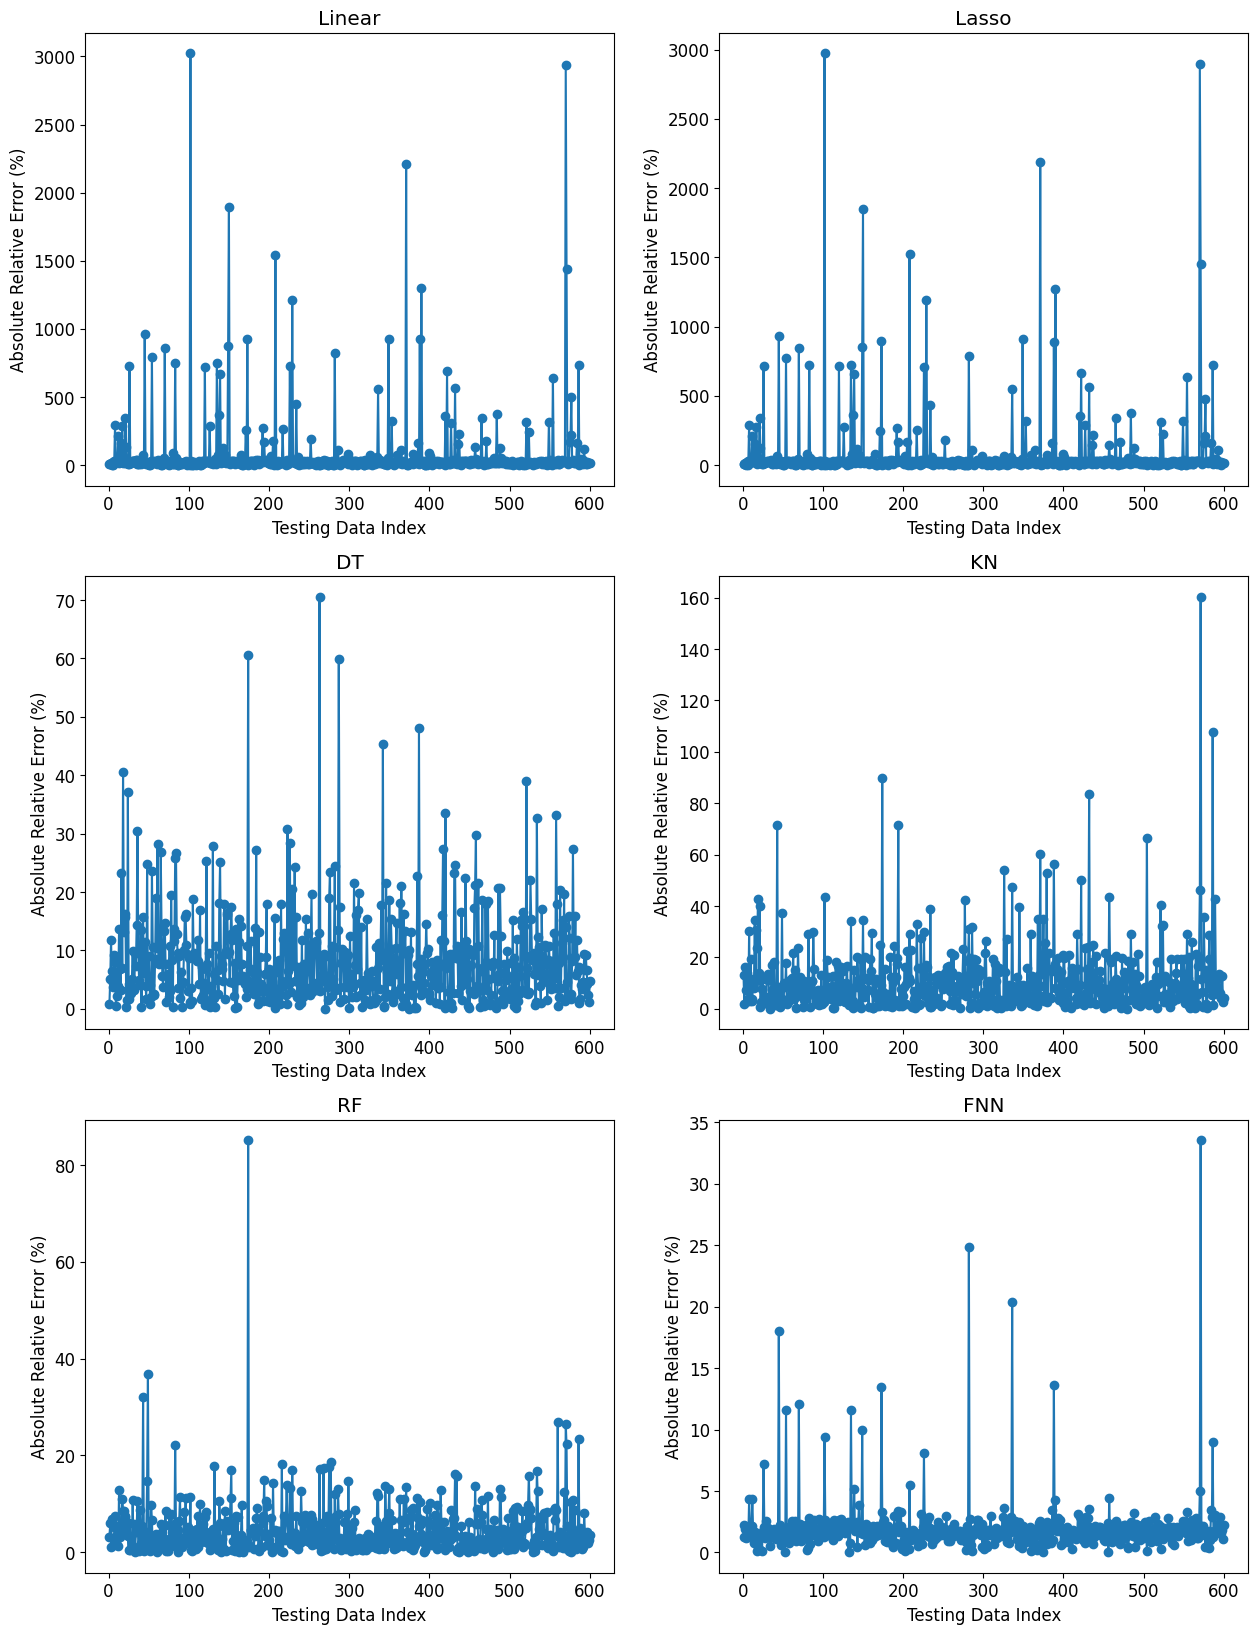

In [23]:
performance_plot(postprocessor.validation_plot, "max_power")

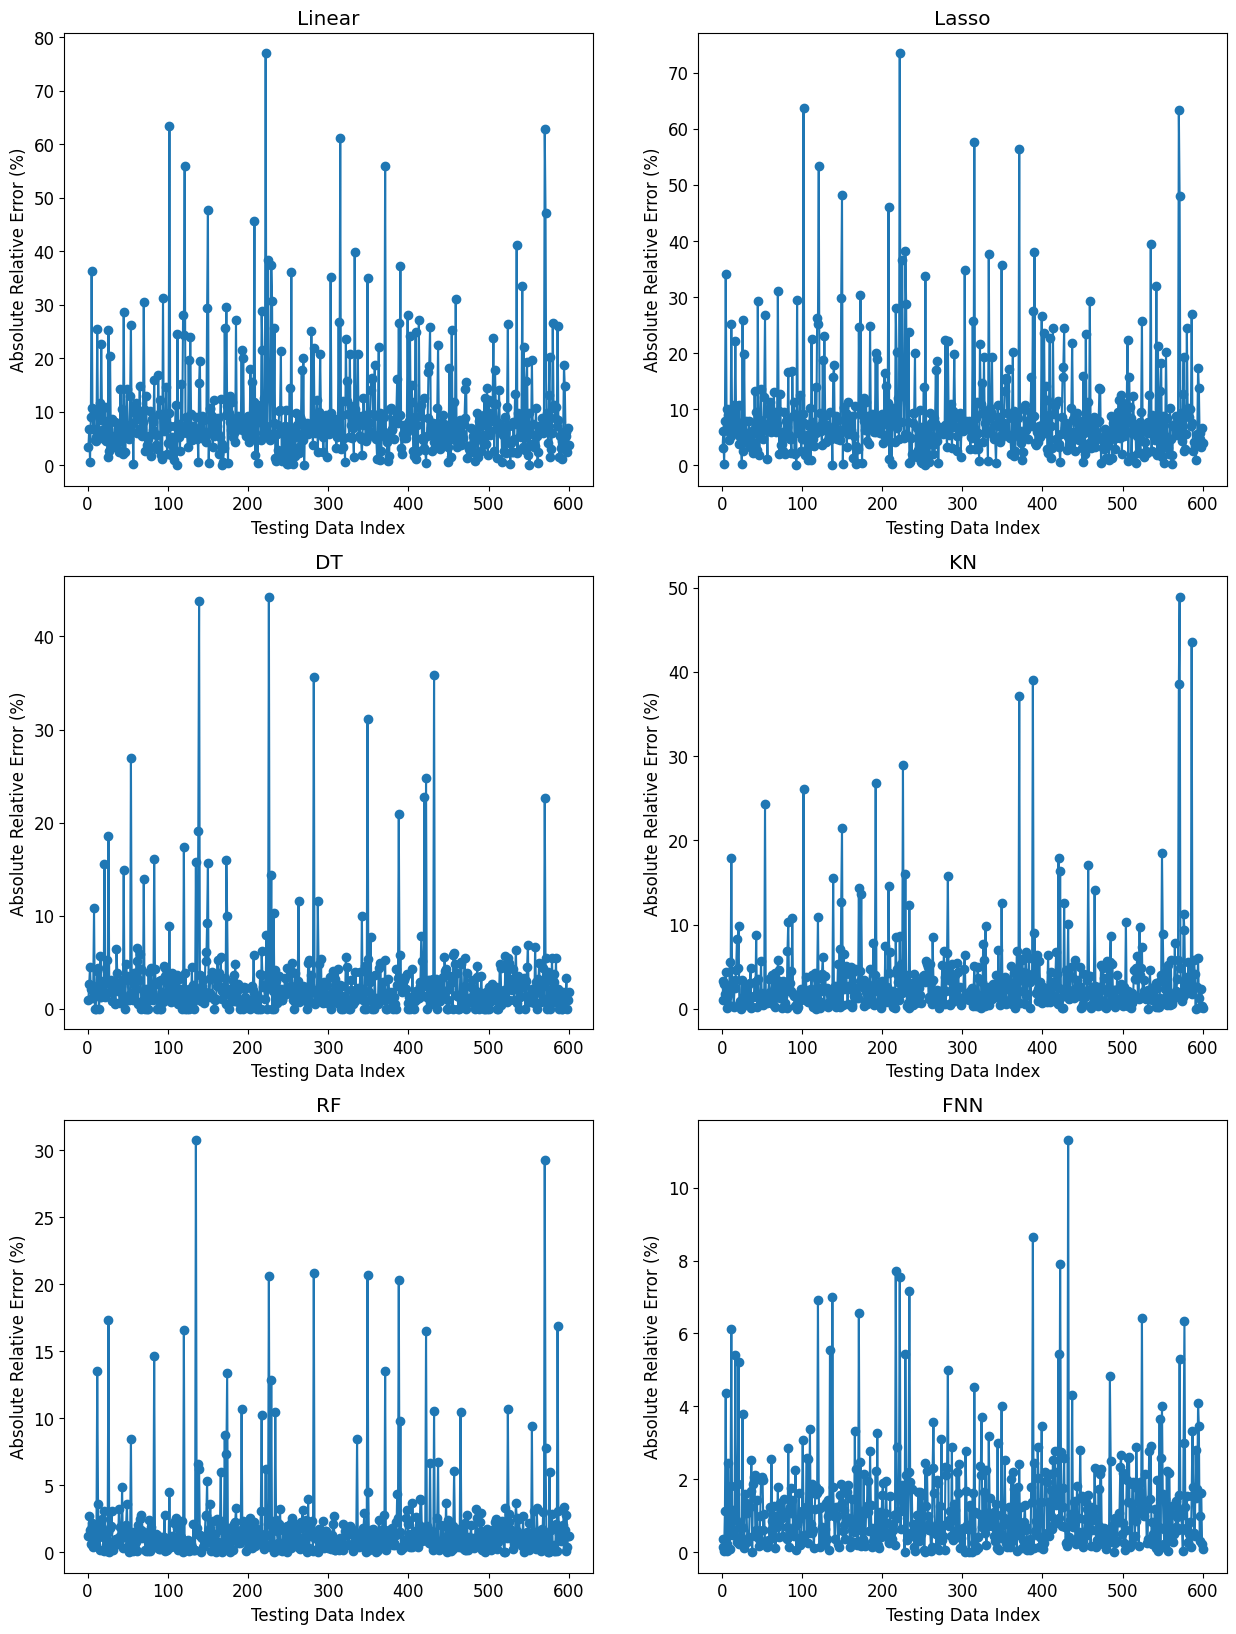

In [24]:
performance_plot(postprocessor.validation_plot, "burst_width")

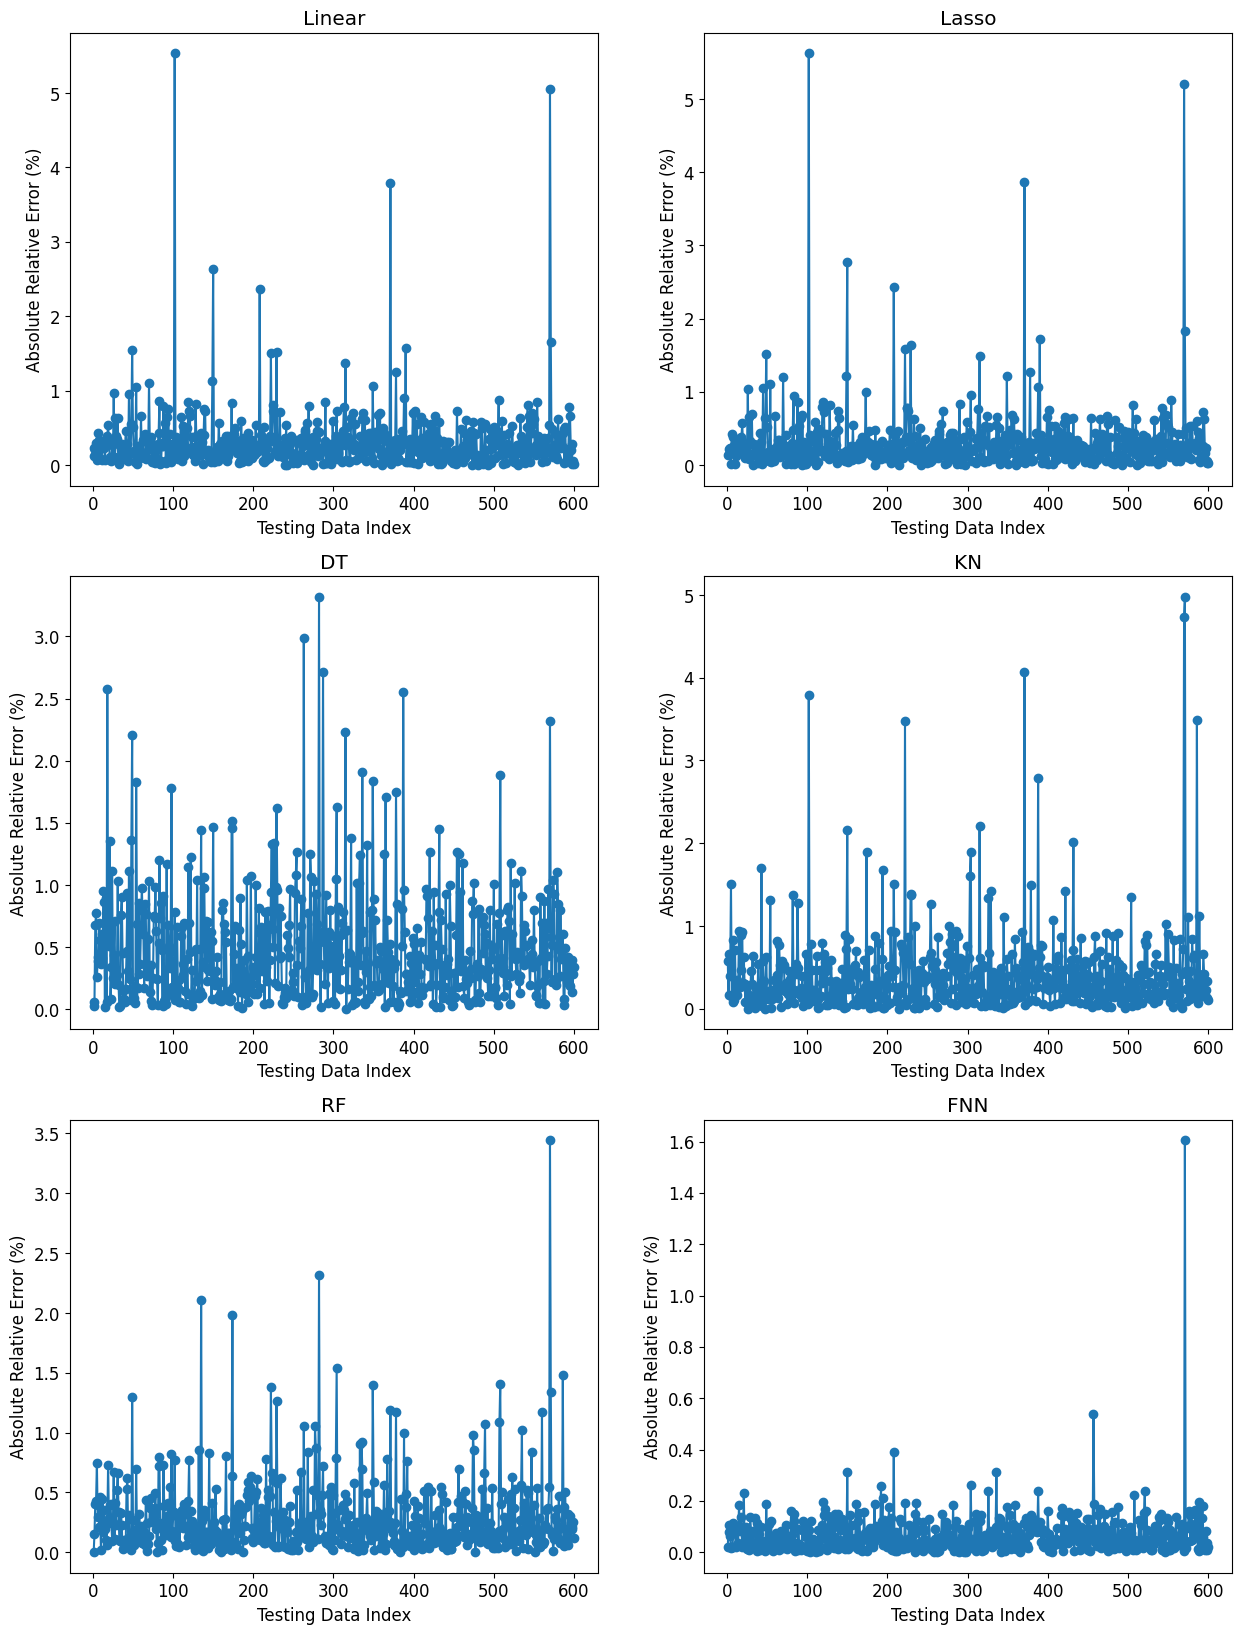

In [25]:
performance_plot(postprocessor.validation_plot, "max_Tf")

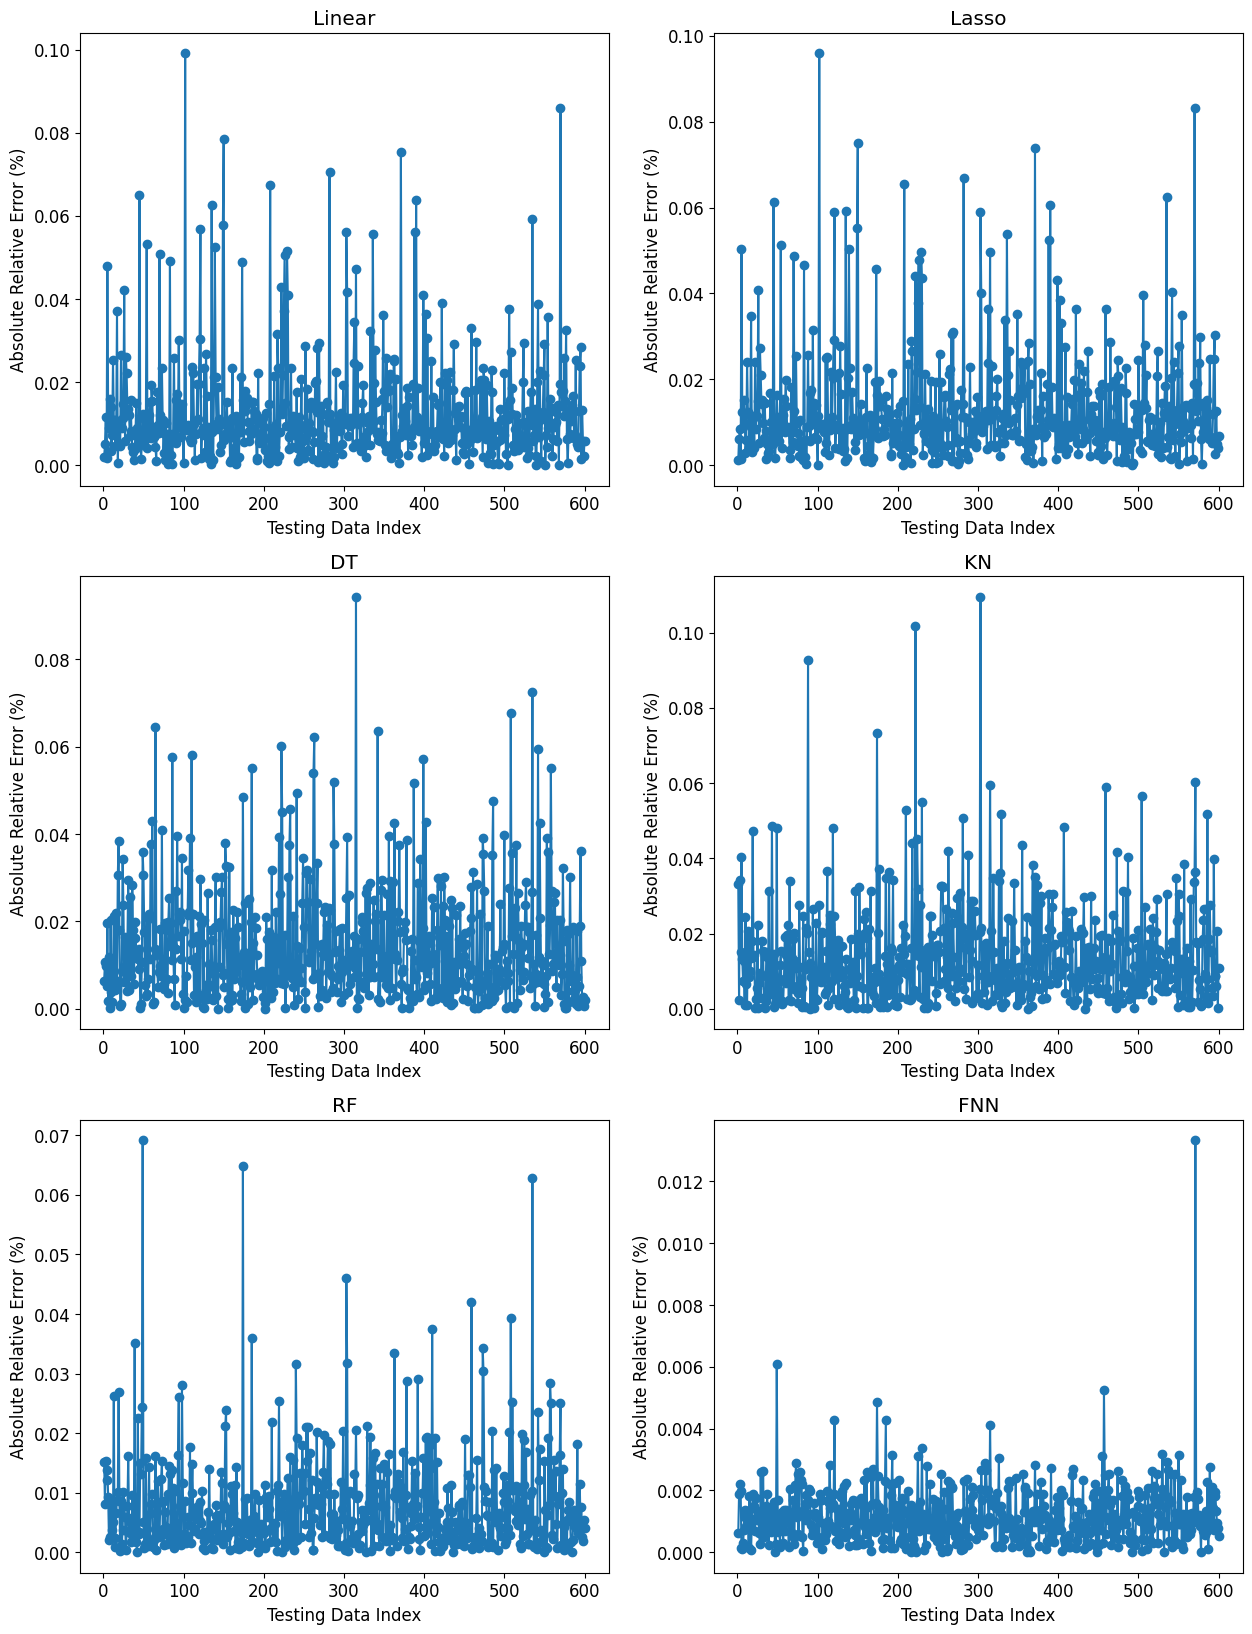

In [26]:
performance_plot(postprocessor.validation_plot, "avg_Tcool")

Finally, the most learning curve for the most performant FNN is shown below. It shows no overfitting, as the validation curve follows the training curve closely.

<Axes: xlabel='Epoch', ylabel='Loss'>

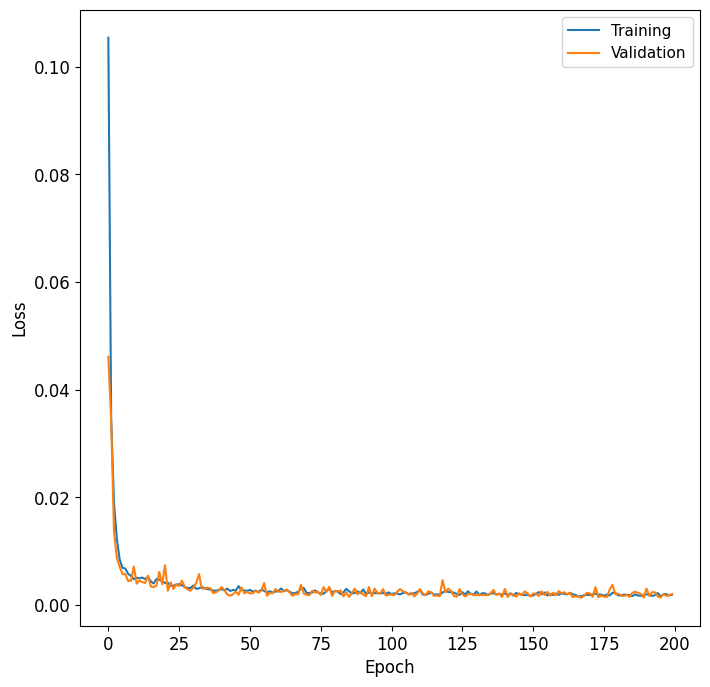

In [27]:
postprocessor.nn_learning_plot()

![pyMAISElogo.png](../_images/pyMAISElogo.png)